# Markowitz Optimization

## 1. Set a Goal

Is the objective to minimise risk or maximise Sharpe Ratio?

## 2. Select Asset Classes

Choose broad asset classes like:

Equities (Domestic and international stocks)
Fixed Income (Government bonds, corporate bonds)
Real Assets (REITs, commodities)
Cash and Cash Equivalents (Money market funds)


## 3. Apply Markovitz Optimization

__Monitor and Rebalance Periodically__

__Frequency__: Rebalance every 6-12 months. This strikes a good balance between maintaining the optimal allocation and minimizing trading costs.

__Thresholds__: Alternatively, rebalance only when an asset class deviates by more than a certain percentage (e.g., 5%) from its target weight.

Rebalancing Steps:

__Check__ your current allocation against the target weights.

__Sell__ assets that are overweight to reduce their allocation.

__Buy__ assets that are underweight to increase their allocation.

In [63]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [49]:
# Define the ticker symbols
tickers = ['SPY', 'QQQ', 'TLT', 'SOXX', 'DIA', 'BSV']

# Fetch historical data
data = yf.download(tickers, start="1999-01-01", end="2014-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()


[*********************100%%**********************]  6 of 6 completed


In [50]:
# Calculate mean daily return and covariance of daily returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

num_assets = len(tickers)
# Initial weights set to equal distribution
weights = np.array([1/num_assets] * num_assets)

In [51]:
mean_returns

Ticker
BSV     0.000143
DIA     0.000361
QQQ     0.000545
SOXX    0.000392
SPY     0.000340
TLT     0.000290
dtype: float64

In [52]:
cov_matrix

Ticker,BSV,DIA,QQQ,SOXX,SPY,TLT
Ticker,,,,,,
BSV,0.000006,-0.000008,-0.000010,-0.000010,-0.000009,0.000009
DIA,-0.000008,0.000191,0.000186,0.000208,0.000201,-0.000063
QQQ,-0.000010,0.000186,0.000227,0.000255,0.000207,-0.000068
SOXX,-0.000010,0.000208,0.000255,0.000379,0.000236,-0.000084
SPY,-0.000009,0.000201,0.000207,0.000236,0.000222,-0.000071
TLT,0.000009,-0.000063,-0.000068,-0.000084,-0.000071,0.000104


# Single Period Optimisation

In [30]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Convert to annual returns
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annual standard deviation
    return std_dev, returns


# Objective function (minimize negative Sharpe ratio)
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_std, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

# Objective function (minimize variance)
def portfolio_variance(weights, mean_returns, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each weight
bounds = tuple((0, 1) for asset in range(num_assets))
optimized_result = minimize(negative_sharpe, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimized weights
optimized_weights = optimized_result.x

print("Optimized Weights:\n")
for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.2%}")

Optimized Weights:

QQQ: 41.28%
SPY: 0.00%
TLT: 58.72%


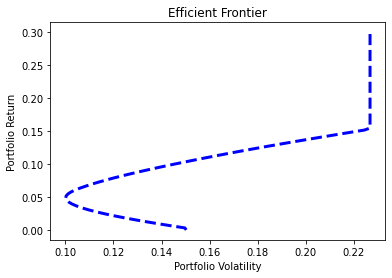

In [10]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

frontier_y = np.linspace(0, 0.3, 100)
frontier_x = []

for possible_return in frontier_y:
    cons = (constraints, {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - possible_return})
    result = minimize(portfolio_volatility, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

plt.plot(frontier_x, frontier_y, 'b--', linewidth=3)
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.show()


# Bootstrap

In [47]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Convert to annual returns
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annual standard deviation
    return std_dev, returns


# Objective function (minimize negative Sharpe ratio)
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_std, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

# Objective function (minimize variance)
def portfolio_variance(weights, mean_returns, cov_matrix):
    return weights.T @ cov_matrix @ weights

def bootstrap_resample(returns, n_bootstraps, n_days, log_steps=100):
    avg_weights = np.zeros(len(returns.columns))
    
    for i in range(n_bootstraps):
        # Resample the returns with replacement
        sample_indices = np.random.choice(range(len(returns)), size=n_days, replace=True)
        resampled_returns = returns.iloc[sample_indices]
        
        # Perform optimization on the resampled data
        weights = optimize_portfolio(resampled_returns)
        avg_weights += weights
        if i % log_steps == 0:
            print("Finished round:", i, weights*100)
    
    avg_weights /= n_bootstraps
    return avg_weights



def optimize_portfolio(rets):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    mean_returns = rets.mean()
    cov_matrix = rets.cov()

    bounds = tuple((0, 1) for asset in range(num_assets))
    optimized_result = minimize(negative_sharpe, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
#     optimized_result = minimize(portfolio_variance, weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)


    optimized_weights = optimized_result.x
    return optimized_weights

In [53]:
weights = bootstrap_resample(returns, 500, 252)

print("Optimized Weights:\n")
for ticker, weight in zip(tickers, weights):
    print(f"{ticker}: {weight:.2%}")

Finished round: 0 [8.24949800e+01 0.00000000e+00 1.75050200e+01 3.13421164e-13
 3.61836212e-13 7.20945656e-13]
Finished round: 100 [1.17693637e-14 1.48999922e+01 0.00000000e+00 1.65875164e+01
 3.22906488e-14 6.85124914e+01]
Finished round: 200 [77.15540844  0.          0.          9.31293012  0.         13.53166144]
Finished round: 300 [7.91127896e+00 6.93889390e-15 2.51541827e+01 3.55446606e+00
 3.88144378e-15 6.33800723e+01]
Finished round: 400 [ 0.          0.         72.15429126  0.          0.         27.84570874]
Optimized Weights:

SPY: 53.40%
QQQ: 6.30%
TLT: 12.82%
SOXX: 5.51%
DIA: 2.77%
BSV: 19.20%


# Validation Sharpe

In [54]:
tickers = ['SPY', 'QQQ', 'TLT', 'SOXX', 'DIA', 'BSV']
data = yf.download(tickers, start="2000-01-01", end="2023-12-31")['Adj Close']
returns = data.pct_change().dropna()

[*********************100%%**********************]  6 of 6 completed


In [100]:
def portfolio_annual_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_std, p_ret = portfolio_annual_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std


def sortino_ratio(weights, returns, target_return=0.0):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    downside_returns = np.where(returns < target_return, returns - target_return, 0)
    downside_risk = np.sqrt(np.mean(np.square(downside_returns)) * 252)
    return -portfolio_return / downside_risk if downside_risk != 0 else float('-inf')


def omega_ratio(weights, returns, threshold_return=0.0):
    threshold_return = threshold_return / 252
    mean_returns = returns @ weights
    relative_returns = mean_returns - threshold_return
    gain = relative_returns[relative_returns > 0].sum()
    loss = -relative_returns[relative_returns < 0].sum()
    return -(gain / loss) if loss != 0 else float('-inf')


def optimize_portfolio(returns, method='sharpe'):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    if method == 'sharpe':
        args = (mean_returns, cov_matrix)
        result = minimize(negative_sharpe, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'sortino':
        args = (returns)
        result = minimize(sortino_ratio, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'omega':
        args = (returns)
        result = minimize(omega_ratio, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
        
    return result.x


def bootstrap_resample(returns, n_bootstraps, n_days, method='sharpe', log_steps=100):
    avg_weights = np.zeros(len(returns.columns))
    
    for i in range(n_bootstraps):
        # Resample the returns with replacement
        sample_indices = np.random.choice(range(len(returns)), size=n_days, replace=True)
        resampled_returns = returns.iloc[sample_indices]
        
        # Consecutive returns sampling (No substantial difference)
#         start_date = np.random.choice(returns.index[:-365])
#         end_date = start_date + np.timedelta64(365, 'D')
#         resampled_returns = returns.loc[start_date:end_date]  # loc: label index range
        
        # Perform optimization on the resampled data
        weights = optimize_portfolio(resampled_returns, method)
        avg_weights += weights
        if (i+1) % log_steps == 0:
            print("Finished round:", i+1, weights*100)
    
    avg_weights /= n_bootstraps
    return avg_weights

In [67]:
window = 10 
years = range(2010, 2024)
sharpe_markowitz = []
ret_markowitz = []
sharpe_equal = []
ret_equal = []

for year in years:
    print("Running year:", year)
    start_year = year - window
    end_year = year - 1
    returns_window = returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"]

    # Optimize portfolio at the end of this window
    optimal_weights = bootstrap_resample(returns_window, 100, 252, log_steps=1000)
    next_year_returns = returns.loc[f"{year}-01-01":f"{year}-12-31"]
    
    # Calculate Sharpe ratio for Markowitz portfolio
    mean_returns = next_year_returns.mean()
    cov_matrix = next_year_returns.cov()
    std_dev, ret = portfolio_annual_performance(optimal_weights, mean_returns, cov_matrix)
    sharpe_markowitz.append((ret - 0.01) / std_dev)
    ret_markowitz.append(ret)

    # Calculate Sharpe ratio for equal weight portfolio
    n_items = returns.shape[1]
    equal_weights = np.array([1/n_items for _ in range(n_items)])
    std_dev, ret = portfolio_annual_performance(equal_weights, mean_returns, cov_matrix)
    sharpe_equal.append((ret - 0.01) / std_dev)
    ret_equal.append(ret)

# Output the results
results = pd.DataFrame({
    'Year': years,
    'Sharpe_Markowitz': sharpe_markowitz,
    'Sharpe_Equal': sharpe_equal,
    'Ret_Markowitz': ret_markowitz,
    'Ret_Equal': ret_equal,
})
print(results)


Running year: 2010
Running year: 2011
Running year: 2012
Running year: 2013
Running year: 2014
Running year: 2015
Running year: 2016
Running year: 2017
Running year: 2018
Running year: 2019
Running year: 2020
Running year: 2021
Running year: 2022
Running year: 2023
    Year  Sharpe_Markowitz  Sharpe_Equal  Ret_Markowitz  Ret_Equal
0   2010          1.706669      1.079562       0.085116   0.136031
1   2011          1.947209      0.536839       0.089090   0.083547
2   2012          1.210184      1.072998       0.053487   0.100357
3   2013          0.718943      2.288798       0.041034   0.187923
4   2014          2.855801      1.990235       0.102544   0.164858
5   2015          0.112670      0.186799       0.015584   0.029594
6   2016          1.126612      1.258885       0.060810   0.128606
7   2017          3.099778      3.351619       0.120064   0.202763
8   2018         -0.116035     -0.117388       0.002277  -0.005484
9   2019          3.228498      2.635761       0.196379   0.2650

In [32]:
# 3 assets
m, s, rm = results['Sharpe_Markowitz'].mean(), results['Sharpe_Markowitz'].std(), results['Ret_Markowitz'].mean()
print("Markowitz sharpe mean:", m, "std:", s, "ret mean:", rm)

m, s, rm = results['Sharpe_Equal'].mean(), results['Sharpe_Equal'].std(), results['Ret_Equal'].mean()
print("Equal sharpe mean:", m, "std:", s, "ret mean:", rm)

Markowitz sharpe mean: 1.3223781997225077 std: 1.2880540249035282 ret mean: 0.11371263894667553
Equal sharpe mean: 1.3241262174511892 std: 1.2262948913189584 ret mean: 0.12340690739909166


In [75]:
# 6 assets
m, s, rm, rs = results['Sharpe_Markowitz'].mean(), results['Sharpe_Markowitz'].std(), results['Ret_Markowitz'].mean(), results['Ret_Markowitz'].std()
print(f"Markowitz sharpe mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

m, s, rm, rs = results['Sharpe_Equal'].mean(), results['Sharpe_Equal'].std(), results['Ret_Equal'].mean(), results['Ret_Equal'].std()
print(f"Equal sharpe mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

Markowitz sharpe mean: 1.35, std:1.30, ret mean: 0.075, ret std: 0.102
Equal sharpe mean: 1.28, std:1.18, ret mean: 0.127, ret std: 0.129


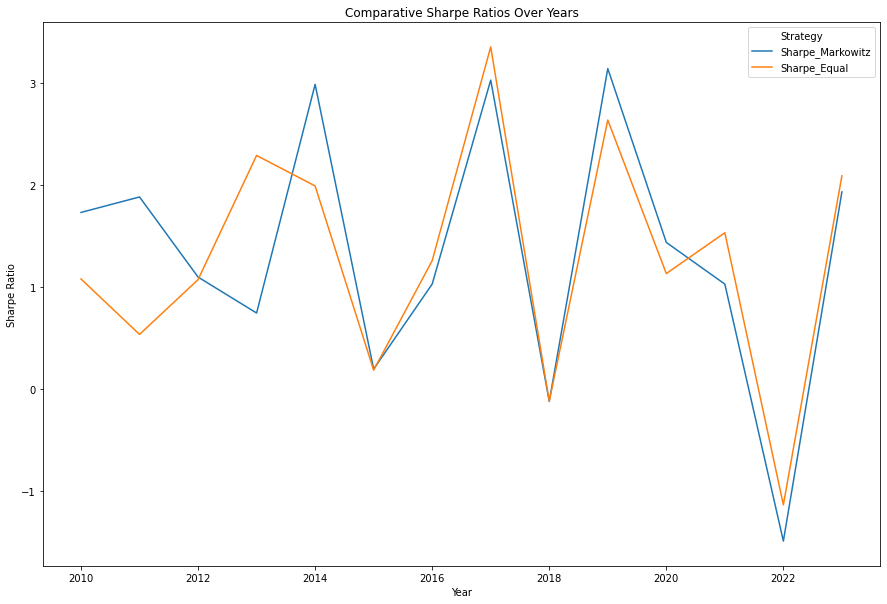

In [65]:
results_melted = results.melt(id_vars='Year', value_vars=['Sharpe_Markowitz', 'Sharpe_Equal'], var_name='Strategy', value_name='Sharpe Ratio')


plt.figure(figsize=(15, 10))
sns.lineplot(data=results_melted, x='Year', y='Sharpe Ratio', hue='Strategy')
plt.title('Comparative Sharpe Ratios Over Years')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.show()

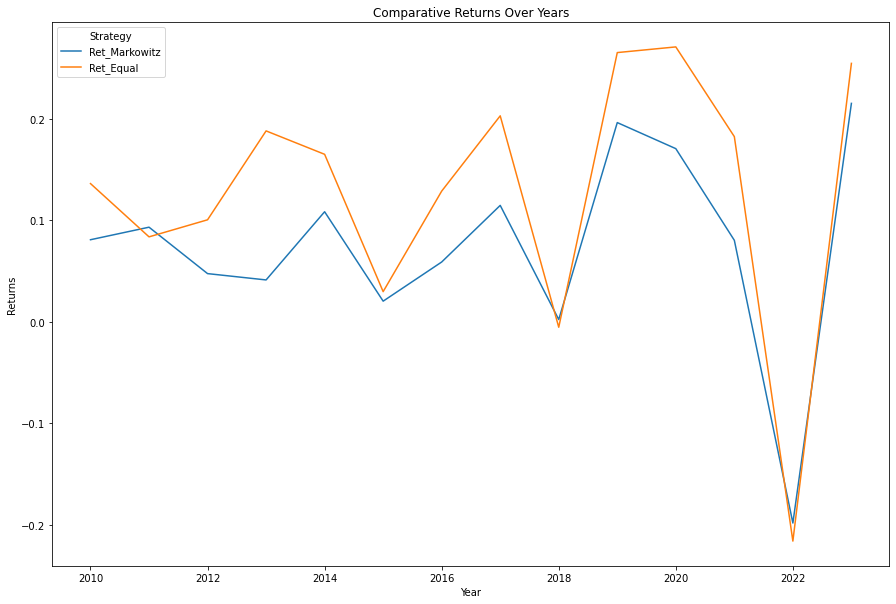

In [66]:
results_melted = results.melt(id_vars='Year', value_vars=['Ret_Markowitz', 'Ret_Equal'], var_name='Strategy', value_name='Return')


plt.figure(figsize=(15, 10))
sns.lineplot(data=results_melted, x='Year', y='Return', hue='Strategy')
plt.title('Comparative Returns Over Years')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()

# Validation Sortino

Sortino Ratio = R_f / downside_deviation

`R_f`: The excessive return above risk free rate.

In [98]:
window = 10 
years = range(2010, 2024)
sharpe_markowitz = []
ret_markowitz = []
sharpe_equal = []
ret_equal = []

for year in years:
    print("Running year:", year)
    start_year = year - window
    end_year = year - 1
    returns_window = returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"]

    # Optimize portfolio at the end of this window
    optimal_weights = bootstrap_resample(returns_window, 100, 252, method='sortino', log_steps=1000)
    next_year_returns = returns.loc[f"{year}-01-01":f"{year}-12-31"]
    
    # Calculate Sharpe ratio for Markowitz portfolio
    mean_returns = next_year_returns.mean()
    cov_matrix = next_year_returns.cov()
    std_dev, ret = portfolio_annual_performance(optimal_weights, mean_returns, cov_matrix)
    sort_ratio = -sortino_ratio(optimal_weights, next_year_returns)
    sharpe_markowitz.append(sort_ratio)
    ret_markowitz.append(ret)

    # Calculate Sharpe ratio for equal weight portfolio
    n_items = returns.shape[1]
    equal_weights = np.array([1/n_items for _ in range(n_items)])
    std_dev, ret = portfolio_annual_performance(equal_weights, mean_returns, cov_matrix)
    sort_ratio = -sortino_ratio(equal_weights, next_year_returns)
    sharpe_equal.append(sort_ratio)
    ret_equal.append(ret)

# Output the results
results = pd.DataFrame({
    'Year': years,
    'Sortino_Markowitz': sharpe_markowitz,
    'Sortino_Equal': sharpe_equal,
    'Ret_Markowitz': ret_markowitz,
    'Ret_Equal': ret_equal,
})
print(results)

Running year: 2010
Running year: 2011
Running year: 2012
Running year: 2013
Running year: 2014
Running year: 2015
Running year: 2016
Running year: 2017
Running year: 2018
Running year: 2019
Running year: 2020
Running year: 2021
Running year: 2022
Running year: 2023
    Year  Sortino_Markowitz  Sortino_Equal  Ret_Markowitz  Ret_Equal
0   2010           1.117909       1.076195       0.141304   0.136031
1   2011           0.916225       0.535602       0.142919   0.083547
2   2012           0.760637       1.048153       0.072828   0.100357
3   2013           2.100829       2.296395       0.171919   0.187923
4   2014           2.641206       1.902958       0.228814   0.164858
5   2015           0.241414       0.262469       0.027220   0.029594
6   2016           1.677134       1.252915       0.172151   0.128606
7   2017           3.249994       2.977897       0.221290   0.202763
8   2018          -0.056299      -0.040400      -0.007642  -0.005484
9   2019           3.584940       2.600507  

In [99]:
# 6 assets
m, s, rm, rs = results['Sortino_Markowitz'].mean(), results['Sortino_Markowitz'].std(), results['Ret_Markowitz'].mean(), results['Ret_Markowitz'].std()
print(f"Markowitz Sortino mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

m, s, rm, rs = results['Sortino_Equal'].mean(), results['Sortino_Equal'].std(), results['Ret_Equal'].mean(), results['Ret_Equal'].std()
print(f"Equal Sortino mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

Markowitz Sortino mean: 1.62, std:1.52, ret mean: 0.167, ret std: 0.190
Equal Sortino mean: 1.28, std:1.13, ret mean: 0.127, ret std: 0.129


In [97]:
print("Optimized Weights:\n")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

Optimized Weights:

SPY: 4.00%
QQQ: 4.00%
TLT: 9.00%
SOXX: 58.00%
DIA: 2.00%
BSV: 23.00%


# Validation Omega

The gains above threshold divided by below threshold.

In [101]:
window = 10 
years = range(2010, 2024)
sharpe_markowitz = []
ret_markowitz = []
sharpe_equal = []
ret_equal = []

for year in years:
    print("Running year:", year)
    start_year = year - window
    end_year = year - 1
    returns_window = returns.loc[f"{start_year}-01-01":f"{end_year}-12-31"]

    # Optimize portfolio at the end of this window
    optimal_weights = bootstrap_resample(returns_window, 100, 252, method='omega', log_steps=1000)
    next_year_returns = returns.loc[f"{year}-01-01":f"{year}-12-31"]
    
    # Calculate Sharpe ratio for Markowitz portfolio
    mean_returns = next_year_returns.mean()
    cov_matrix = next_year_returns.cov()
    std_dev, ret = portfolio_annual_performance(optimal_weights, mean_returns, cov_matrix)
    omg_ratio = -omega_ratio(optimal_weights, next_year_returns)
    sharpe_markowitz.append(omg_ratio)
    ret_markowitz.append(ret)

    # Calculate Sharpe ratio for equal weight portfolio
    n_items = returns.shape[1]
    equal_weights = np.array([1/n_items for _ in range(n_items)])
    std_dev, ret = portfolio_annual_performance(equal_weights, mean_returns, cov_matrix)
    omg_ratio = -omega_ratio(equal_weights, next_year_returns)
    sharpe_equal.append(omg_ratio)
    ret_equal.append(ret)

# Output the results
results = pd.DataFrame({
    'Year': years,
    'Omega_Markowitz': sharpe_markowitz,
    'Omega_Equal': sharpe_equal,
    'Ret_Markowitz': ret_markowitz,
    'Ret_Equal': ret_equal,
})
print(results)

Running year: 2010
Running year: 2011
Running year: 2012
Running year: 2013
Running year: 2014
Running year: 2015
Running year: 2016
Running year: 2017
Running year: 2018
Running year: 2019
Running year: 2020
Running year: 2021
Running year: 2022
Running year: 2023
    Year  Omega_Markowitz  Omega_Equal  Ret_Markowitz  Ret_Equal
0   2010         1.372801     1.221550       0.084491   0.136031
1   2011         1.470848     1.109805       0.100432   0.083547
2   2012         1.309670     1.217043       0.045110   0.100357
3   2013         1.234636     1.500683       0.038487   0.187923
4   2014         1.598881     1.420026       0.081377   0.164858
5   2015         1.076953     1.049230       0.016974   0.029594
6   2016         1.234530     1.272380       0.051132   0.128606
7   2017         1.733217     1.831706       0.079936   0.202763
8   2018         1.008687     0.992735       0.003205  -0.005484
9   2019         1.834541     1.587051       0.137848   0.265069
10  2020         1.

In [102]:
# 6 assets
m, s, rm, rs = results['Omega_Markowitz'].mean(), results['Omega_Markowitz'].std(), results['Ret_Markowitz'].mean(), results['Ret_Markowitz'].std()
print(f"Markowitz Omega mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

m, s, rm, rs = results['Omega_Equal'].mean(), results['Omega_Equal'].std(), results['Ret_Equal'].mean(), results['Ret_Equal'].std()
print(f"Equal Omega mean: {m:.2f}, std:{s:.2f}, ret mean: {rm:.3f}, ret std: {rs:.3f}")

print("Optimized Weights:\n")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

Markowitz Omega mean: 1.34, std:0.28, ret mean: 0.061, ret std: 0.075
Equal Omega mean: 1.29, std:0.26, ret mean: 0.127, ret std: 0.129
Optimized Weights:

SPY: 45.38%
QQQ: 12.32%
TLT: 10.87%
SOXX: 13.47%
DIA: 2.56%
BSV: 15.40%
